In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import Libraries

# DS 
import os
from itertools import islice
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import seaborn as sns

# PLOTLY
import plotly.offline as po
import plotly.graph_objs as go

# SKLEARN
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import (GradientBoostingRegressor, 
                              GradientBoostingClassifier, 
                              AdaBoostClassifier,
                              AdaBoostRegressor,
                              RandomForestRegressor,
                              RandomForestClassifier)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, confusion_matrix, accuracy_score, plot_roc_curve
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

import warnings
warnings.filterwarnings('ignore')

# Aesthetic Plots
import mplcyberpunk
plt.style.use('cyberpunk')
%matplotlib inline

In [3]:
from src.gradient_clean_data import *

In [4]:
# GLOBAL VARS
FSIZE = (12, 8)

In [5]:
# Load CSV
df = pd.read_csv('data/Train.csv')

In [6]:
# Clean and Split
X, y = gradient_clean_Xy(df)

In [7]:
# Drop Datetime Column
X.drop(columns=['saledate'], inplace=True)

In [8]:
# Create labels to encode
to_encode = X.select_dtypes(include=['object']).columns.tolist()

# Encode Labels
X, encode_dict = encode_labels(X, to_encode)

In [9]:
# Plot Features
fig = plt.figure(figsize=(15,7), dpi=1600) # sets our figure size and resolution 

# Plot Targets
target = y
target_log = np.log(y) # transforms sales price
a=.65 # sets the alpha level

ax1 = plt.subplot2grid((2, 3), (0, 1))# creates a grid to hold mulptile plots, as well 
target.plot(kind='kde')         #    as the location of this plot in the grid
plt.title("Distribution of Sales"); plt.legend(loc='best')

ax2 = plt.subplot2grid((2, 3), (0, 2), colspan=2)
target_log.plot(kind='kde')
plt.title("Logged Distribution of Sales"); plt.legend(loc='best')

year_made = X["YearMade"].value_counts().sort_index()
ax3 = plt.subplot2grid((2, 3), (0, 0), colspan=1, rowspan=2)
year_made.plot(kind='barh', alpha=a)
plt.title("When were these bulldozers made?")
plt.xlabel('Count')
plt.ylabel('Year')

vehicle_size = X["ProductSize"].value_counts()
ax4 = plt.subplot2grid((2, 3), (1, 2), rowspan=2)
vehicle_size.plot(kind='bar',alpha=a)
plt.title("Distribution of Bulldozer Sizes")

usage_bands = X["UsageBand"].value_counts()
ax5 = plt.subplot2grid((2, 3), (1, 1))
usage_bands.plot(kind='bar', alpha=a)
plt.title("Distribution of Hours the Dozers were used. ")

fig.subplots_adjust(hspace=1, wspace=1)
plt.tight_layout()

In [10]:
# Train Test Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)    

In [30]:
# Create GradientBoostingRegressor Model
gb_model = GradientBoostingRegressor(learning_rate=0.05,
                                     n_estimators=150,
                                     max_depth=4,
                                     max_features=9,
                                     min_samples_leaf=2,
)

In [31]:
# Fit Model
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls', max_depth=4,
                          max_features=9, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=2, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

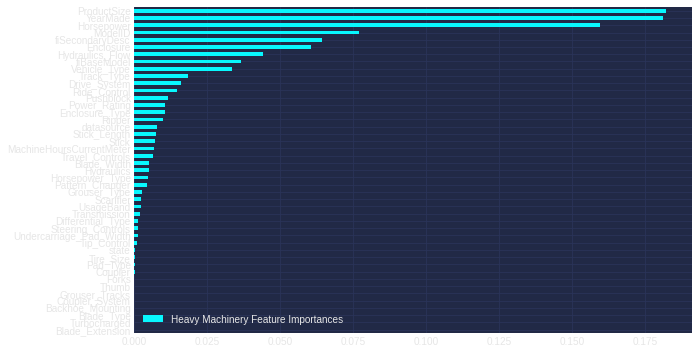

In [32]:
# Find Feature Importances via GB Model

# See and plot feature importances 
feat_scores = pd.DataFrame({'Heavy Machinery Feature Importances' : gb_model.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Heavy Machinery Feature Importances')
feat_scores.plot(kind='barh', figsize=(10, 6))

In [33]:
# Gradient Boosting Prediction
y_pred = gb_model.predict(X_test)

In [34]:
mean_error = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Mean Error: {mean_error}")

Mean Error: 12388.296083066058


In [35]:
sum(y_pred > 60000), sum(y_pred < 60000)

(8128, 92154)

In [36]:
max(y_test), min(y_test)

(142000, 4750)

In [37]:
max(y_pred), min(y_pred)

(134481.79398232646, 2945.6146948217515)

# Grid Search

In [38]:
# gb_grid = {'loss': ['deviance','exponential'],'n_estimators': [100,150,200],
#                   'min_samples_leaf': [1,2,3],
#                   'max_depth': [3,4,6],
#                   'max_features': [3,5,9],
#                   'learning_rate': [.05,.1,.15,.2]}

# gb_gridsearch = GridSearchCV(GradientBoostingClassifier(),
#                              gb_grid,
#                              n_jobs=-1,
#                              verbose=True,
#                              scoring='accuracy')

# gb_gridsearch.fit(X_train, y_train)

# print( "Best Params:", gb_gridsearch.best_params_ )

In [39]:
# model_gbc_best = gb_gridsearch.best_estimator_